In [2]:
import math
import numpy as np
import pandas as pd
import pickle
import os
import gc
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import seaborn as sns
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
from cvxopt import solvers,matrix


# Packages for feature extraction and model training
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# Importing sklearn and TSNE.
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

C:\Users\Madhu\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


Defining Kernel Functions

In [1]:
def kernelfunction(Type, u, v, p):
    # u, v are array like; p is parameter for kernels; type is:
        # type 1 linear kernel
        # type 2 polynomial kernel
        # type 3 RBF kernels
    if(Type==1):
        return np.dot(u,v)
    if(Type==2):
        return pow(np.dot(u,v)+1,p)
    if(Type==3):
        temp = u-v
        return pow(math.e,(-np.dot(temp,temp)/(p**2)))

def centertrainKernel(K):
    m,n = K.shape
    if(m!=n):
        print("Interrupt!, invalid Kernel")
    else:
        In = np.ones(m,m)/m
        K += np.dot(In,np.dot(K,In)) - (np.dot(K,In)+np.dot(In,K))
        return K

def centertestKernel(K):
    # here K = L*M, L is test data no of points, and M is train data no of points
    l,m = K.shape
    In = np.ones(m,m)/m
    Im = np.ones(l,m)/m
    K += np.dot(Im,np.dot(K,In)) - (np.dot(K,In)+np.dot(Im,K))
    return K

Function for calculating parameters of hyperplane1

In [2]:
def Twin_plane1(R,S,C1,Eps1,reg1):
	SS = np.dot(S.T,S)
	SS = SS + reg1*(np.identity(SS.shape[0]))
	SSR = linalg.solve(SS,R.T)
	RSSR = np.dot(R,SSR)
	RSSR = (RSSR+(RSSR.T))/2
	m2 = R.shape[0]
	e2 = -np.ones((m2,1))
	solvers.options['show_progress'] = False
	vlb = np.zeros((m2,1))
	vub = C1*(np.ones((m2,1)))
	cd = np.vstack((np.identity(m2),-np.identity(m2)))
	vcd = np.vstack((vub,-vlb))
	alpha = solvers.qp(matrix(RSSR,tc='d'),matrix(e2,tc='d'),matrix(cd,tc='d'),matrix(vcd,tc='d'))
	alpha_sol = np.array(alpha['x'])
	z = -np.dot(SSR,alpha_sol)
	w1 = z[:len(z)-1]
	b1 = z[len(z)-1]
	return [w1,b1]

Function to calculate parameters of hyperplane2

In [3]:
def Twin_plane_2(L,N,C2,Eps2,reg2):
	NN = np.dot(N.T,N)
	NN = NN + reg2*(np.identity(NN.shape[0]))
	NNL = linalg.solve(NN,L.T)
	LNNL = np.dot(L,NNL)
	LNNL = (LNNL+(LNNL.T))/2
	m1 = L.shape[0]
	e1 = -np.ones((m1,1))
	solvers.options['show_progress'] = False
	vlb = np.zeros((m1,1))
	vub = C2*(np.ones((m1,1)))
	cd = np.vstack((np.identity(m1),-np.identity(m1)))
	vcd = np.vstack((vub,-vlb))
	gamma = solvers.qp(matrix(LNNL,tc='d'),matrix(e1,tc='d'),matrix(cd,tc='d'),matrix(vcd,tc='d'))
	gammasol = np.array(gamma['x'])
	z = -np.dot(NNL,gammasol)
	w2 = z[:len(z)-1]
	b2 = z[len(z)-1]
	return [w2,b2]

Twin Support Vector Machine Classifier Function

In [4]:
class TSVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,Epsilon_1=0.1, Epsilon_2=0.1, C1=1, C2=1,kernel_type=0,kernel_parameter=1,reg1=1, reg2=1,fuzzy=0,_estimator_type="classifier"):
        self.Epsilon_1=Epsilon_1
        self.Epsilon_2=Epsilon_2
        self.C1=C1
        self.C2=C2
        self.reg1 = reg1
        self.reg2 = reg2
        self.fuzzy = fuzzy
        self.kernel_type=kernel_type
        self.kernel_parameter=kernel_parameter
        
    def fit(self, X, Y):
        assert (type(self.Epsilon_1) in [float,int])
        assert (type(self.Epsilon_2) in [float,int])
        assert (type(self.C1) in [float,int])
        assert (type(self.C2) in [float,int])
        assert (type(self.reg1) in [float,int])
        assert (type(self.reg2) in [float,int])
        assert (self.fuzzy in [0,1])
        assert (type(self.kernel_paramete) in [float,int])
        assert (self.kernel_type in [0,1,2,3])
      
        data = sorted(zip(Y,X), key=lambda pair: pair[0], reverse = True)
        Total = np.array([np.array(x) for y,x in data])
        A=np.array([np.array(x) for y,x in data if (y==1)])
        B=np.array([np.array(x) for y,x in data if (y==0)])
       
        if(self.fuzzy==1):
            if(self.kernel_type==0):
                rpos=0
                rneg=0
                xpos = np.true_divide(sum(A),len(A))
                for a in A:
                    if(rpos<np.linalg.norm(a-xpos)):
                        rpos = np.linalg.norm(a-xpos)
                xneg = np.true_divide(sum(B),len(B))
                for b in B:
                    if(rneg<np.linalg.norm(b-xneg)):
                        rneg = np.linalg.norm(b-xneg)
                self.xpos_ = xpos
                self.xneg_ = xneg
                self.rpos_ = rpos
                self.rneg_ = rneg
            else:
                rpossq=-np.inf
                termt_1=0
                for i in range(len(A)):
                    t1 = kernelfunction(self.kernel_type,A[i],A[i],self.kernel_parameter)
                    t2 = 0
                    for j in range(len(A)):
                        t2 += kernelfunction(self.kernel_type,A[j],A[i],self.kernel_paramter)
                        termt_1 += kernelfunction(self.kernel_type,A[i],A[j],self.kernel_parameter)
                    t2 = -2*t2/len(A)
                    rpossq = max(rpossq,t1+t2)
                termt_1 = termt_1/(len(A)*len(A))
                rpossq += termt_1
                rnegsq=-np.inf
                termt_2=0
                for i in range(len(B)):
                    t1 = kernelfunction(self.kernel_type,B[i],B[i],self.kernel_parameter)
                    t2 = 0
                    for j in range(len(B)):
                        t2 += kernelfunction(self.kernel_type,B[j],B[i],self.kernel_parameter)
                        termt_2 += kernelfunction(self.kernel_type,B[i],B[j],self.kernel_parameter)
                    t2 = -2*t2/len(B)
                    rnegsq = max(rnegsq,t1+t2)
                termt_2 = termt_2/(len(B)*len(B))
                rnegsq += termt_2
                self.rpossq_ = rpossq
                self.rnegsq_ = rnegsq
                self.termt_1_ = termt_1
                self.termt_2_ = termt_2
        m1 = A.shape[0]
        m2 = B.shape[0]
        e1 = -np.ones((m1,1))
        e2 = -np.ones((m2,1))
        if(self.kernel_type==0): 
            S = np.hstack((A,-e1))
            R = np.hstack((B,-e2))
        else:
            S = np.zeros((A.shape[0],Total.shape[0]))
            for i in range(A.shape[0]):
                for j in range(Total.shape[0]):
                    S[i][j] = kernelfunction(self.kernel_type,A[i],Total[j],self.kernel_parameter)
            S = np.hstack((S,-e1))
            R = np.zeros((B.shape[0],Total.shape[0]))
            for i in range(B.shape[0]):
                for j in range(Total.shape[0]):
                    R[i][j] = kernelfunction(self.kernel_type,B[i],Total[j],self.kernel_parameter)
            R = np.hstack((R,-e2))

        #Calculation of Parameters for Equation of planes 
        [w1,b1] = Twin_plane1(R,S,self.C1,self.Epsilon_1,self.reg1)
        [w2,b2] = Twin_plane_2(S,R,self.C2,self.Epsilon_2,self.reg2)
        self.plane1_coeff_ = w1
        self.plane1_offset_ = b1
        self.plane2_coeff_ = w2
        self.plane2_offset_ = b2
        self.data_ = Total
        self.A_ = A
        self.B_ = B
        return self


    def get_parameters(self, deep=True):
        return {"Epsilon_1": self.Epsilon-1, "Epsilon_2": self.Epsilon_2, "C1": self.C1, "C2": self.C2, "reg1": self.reg1,
                "reg2":self.reg2, "kernel_type": self.kernel_type, "kernel_param": self.kernel_param,"fuzzy": self.fuzzy}

    def set_parameters(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

    def predict(self, X, y=None):
        if(self.kernel_type==0): 
            S = X
            w1abs = np.linalg.norm(self.plane1_coeff_)
            w2abs = np.linalg.norm(self.plane2_coeff_)
        else:
            S = np.zeros((self.data_.shape[0],self.data_.shape[0]))
            for i in range(self.data_.shape[0]):
                for j in range(self.data_.shape[0]):
                    S[i][j] = kernelfunction(self.kernel_type,self.data_[i],self.data_[j],self.kernel_parameter)
            w1abs = np.sqrt(np.dot(np.dot(self.plane1_coeff_.T,S),self.plane1_coeff_))
            w2abs = np.sqrt(np.dot(np.dot(self.plane2_coeff_.T,S),self.plane2_coeff_))
            S = np.zeros((X.shape[0],self.data_.shape[0]))
            for i in range(X.shape[0]):
                for j in range(self.data_.shape[0]):
                    S[i][j] = kernelfunction(self.kernel_type,X[i],self.data_[j],self.kernel_parameter)
        y1 = np.dot(S,self.plane1_coeff_)+ ((self.plane1_offset_)*(np.ones((X.shape[0],1))))
        y2 = np.dot(S,self.plane2_coeff_)+ ((self.plane2_offset_)*(np.ones((X.shape[0],1))))

        #Test data predictions
        yPredict=np.zeros((X.shape[0],1))

        distPlane1 = y1/w1abs 
        distPlane2 = y2/w2abs 

        for i in range(len(distPlane1)):
            if (distPlane1[i]<distPlane2[i]):
                yPredict[i][0]=0
            else:
                yPredict[i][0]=1

        return yPredict.transpose()[0]    

    def decision_function(self,X):
       
        if(self.fuzzy==1):
            s1=[]
            s2=[]  
            if(self.kernel_type==0): 
                for i in range(len(X)):
                    s1.append(1-(np.linalg.norm(self.xcenpos_-X[i])/self.rpos_))
                    s2.append(1-(np.linalg.norm(self.xcenneg_-X[i])/self.rneg_))
            else:
                for i in range(len(X)):
                    dsqpos = kernelfunction(self.kernel_type,X[i],X[i],self.kernel_parameter)
                    t1 = 0
                    for j in range(len(self.A_)):
                        t1 += kernelfunction(self.kernel_type,self.A_[j],X[i],self.kernel_parameter)
                    t1 = -2*t1/len(self.A_)
                    dsqpos += t1
                    dsqpos += self.termt_1_
                    s1.append(1-np.sqrt(dsqpos/self.rpossq_))
                    dsqneg = kernelfunction(self.kernel_type,X[i],X[i],self.kernel_parameter)
                    t1 = 0
                    for j in range(len(self.B_)):
                        t1 += kernelfunction(self.kernel_type,self.B_[j],X[i],self.kernel_parameter)
                    t1 = -2*t1/len(self.B_)
                    dsqneg += t1
                    dsqneg += self.termt_2_
                    s2.append(1-np.sqrt(dsqneg/self.rnegsq_))
            s1 = np.array(s1)
            s2 = np.array(s2)
            return np.true_divide(s1,s1+s2)-0.5
        else:
            if(self.kernel_type==0): 
                S = X
                w1abs = np.linalg.norm(self.plane1_coeff_)
                w2abs = np.linalg.norm(self.plane2_coeff_)
            else:
                S = np.zeros((self.data_.shape[0],self.data_.shape[0]))
                for i in range(self.data_.shape[0]):
                    for j in range(self.data_.shape[0]):
                        S[i][j] = kernelfunction(self.kernel_type,self.data_[i],self.data_[j],self.kernel_parameter)
                w1abs = np.sqrt(np.dot(np.dot(self.plane1_coeff_.T,S),self.plane1_coeff_))
                w2abs = np.sqrt(np.dot(np.dot(self.plane2_coeff_.T,S),self.plane2_coeff_))
                S = np.zeros((X.shape[0],self.data_.shape[0]))
                for i in range(X.shape[0]):
                    for j in range(self.data_.shape[0]):
                        S[i][j] = kernelfunction(self.kernel_type,X[i],self.data_[j],self.kernel_parameter)
            y1 = np.dot(S,self.plane1_coeff_)+ ((self.plane1_offset_)*(np.ones((X.shape[0],1))))
            y2 = np.dot(S,self.plane2_coeff_)+ ((self.plane2_offset_)*(np.ones((X.shape[0],1))))

        #Test data predictions
            yPredict=np.zeros((X.shape[0],1))

            distPlane1 = y1/w1abs
            distPlane2 = y2/w2abs 
       
        #Test data predictions
            for i in range(len(distPlane1)):
                yPredict[i][0] = distPlane2[i]/(distPlane1[i]+distPlane2[i])-0.5
            return yPredict.transpose()[0]

### Functions to extract features from layers of VGG16 models

In [3]:
def features(image_path,Models):
    features=[]
    #layername=['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']
    for i in range(5):
            model = Models[i]
            img = image.load_img(image_path, target_size=(645, 484))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            layer_features = model.predict(x)
            layer_features=np.mean(layer_features,axis=(1,2))
            features.append(layer_features)
    Models=[]
    return features

def finalfeatures(image_path,model):
    img = image.load_img(image_path, target_size=(645, 484))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features 

### Read image names and corresponding phases from excel file and split them based on phase names

In [4]:
filename=r"data\metadata.xlsx"
dataread=pd.read_excel(filename,'metadata',index_col=None, na_values=['NA'])
head=dataread.columns.values.tolist()
prim_constituents=dataread["primary_microconstituent"].values.tolist()
microid=dataread["micrograph_id"].values.tolist()
spheroidite_id=[]
network_id=[]
pearlite_id=[]
Widmanstatten_id=[]
pearandsph_id=[]
pearandwid_id=[]
martensite_id=[]
for i in range(len(dataread)):
    if prim_constituents[i]=='spheroidite':
        spheroidite_id.append(microid[i])
    if prim_constituents[i]=='network':
        network_id.append(microid[i])
    if prim_constituents[i]=='pearlite':
        pearlite_id.append(microid[i])
    if prim_constituents[i]=='spheroidite+widmanstatten':
        Widmanstatten_id.append(microid[i])
    if prim_constituents[i]=='pearlite+spheroidite':
        pearandsph_id.append(microid[i])
    if prim_constituents[i]=='pearlite+widmanstatten':
        pearandwid_id.append(microid[i])
    if prim_constituents[i]=='martensite':
        martensite_id.append(microid[i])
spheroidite_train=spheroidite_id[0:100]
spheroidite_test=spheroidite_id[100:]
network_train=network_id[0:100]
network_test=network_id[100:]
pearlite_train=perlite_id[0:100]
pearlite_test=perlite_id[100:]
Widmanstatten_train=Widmanstatten_id[0:60]
Widmanstatten_test=Widmanstatten_id[60:]
train_set=[spheroidite_train,network_train,pearlite_train,Widmanstatten_train]
test_set=[spheroidite_test,network_test,pearlite_test,Widmanstatten_test]
yy=['spheroidite','network','pearlite','Widmanstatten']

### load VGG16 model with different intermediate layer outputs

In [5]:
base_model = VGG16(weights='imagenet', include_top=False)
layer_name=['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']
Models=[]
for i in range(5):
    Models.append(Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name[i]).output))

### Use different intermediate layers of VGG16 to extract features from images

In [7]:
ex_features=[0,0,0,0]

for ii in range(4):
    label=train_set[ii]
    ex_features[ii]=[]
    for i in range(len(label)):
        image_path=r"Data\Micrographs\micrograph"+str(label[i])+"[cropped].tif"
        result=ex_features(image_path,Models)
        ex_features[ii].append(result)
        gc.collect()
        print('finish '+str(ii)+' '+str(i))
    print('finish '+str(ii))        
    with open('objs.pkl', 'wb') as f:  
        pickle.dump(ex_features, f)            
    f.close()            
with open('objs.pkl','rb') as f: 
    ex_features = pickle.load(f)
f.close()

start features mid layers
finish 0 0
finish 0 1
finish 0 2
finish 0 3
finish 0 4
finish 0 5
finish 0 6
finish 0 7
finish 0 8
finish 0 9
finish 0 10
finish 0 11
finish 0 12
finish 0 13
finish 0 14
finish 0 15
finish 0 16
finish 0 17
finish 0 18
finish 0 19
finish 0 20
finish 0 21
finish 0 22
finish 0 23
finish 0 24
finish 0 25
finish 0 26
finish 0 27
finish 0 28
finish 0 29
finish 0 30
finish 0 31
finish 0 32
finish 0 33
finish 0 34
finish 0 35
finish 0 36
finish 0 37
finish 0 38
finish 0 39
finish 0 40
finish 0 41
finish 0 42
finish 0 43
finish 0 44
finish 0 45
finish 0 46
finish 0 47
finish 0 48
finish 0 49
finish 0 50
finish 0 51
finish 0 52
finish 0 53
finish 0 54
finish 0 55
finish 0 56
finish 0 57
finish 0 58
finish 0 59
finish 0 60
finish 0 61
finish 0 62
finish 0 63
finish 0 64
finish 0 65
finish 0 66
finish 0 67
finish 0 68
finish 0 69
finish 0 70
finish 0 71
finish 0 72
finish 0 73
finish 0 74
finish 0 75
finish 0 76
finish 0 77
finish 0 78
finish 0 79
finish 0 80
finish 0 81


### Evaluate the performance of the features extracted by different layers using SVM classifier, pick the most accurate feature-extracting layer

In [11]:
classifier_score=[0,0,0,0,0,0]
classifier_names=[0,0,0,0,0,0]
a=0   

for ii in range(4-1):
    for jj in range(ii+1,4):
        X1=ex_features[ii]
        y1=[yy[ii]]*len(X1)
        X2=ex_features[jj]
        y2=[yy[jj]]*len(X2)
        y=y1[:]
        classifier_score[a]=[]
        classifier_names[a]=yy[ii]+" "+yy[jj]
        for n in y2:
            y.append(n)
        for i in range(5):
            X=[]
            for n in range(len(X1)):
                XX1=X1[n][i][0]
                X.append(XX1.flatten())
            for n in range(len(X2)):
                XX2=X2[n][i][0]
                X.append(XX2.flatten())
            clf = svm.SVC()
            scores = cross_val_score(clf, X, y, scoring='accuracy',cv=10)
            mean_score=scores.mean()
            classifier_score[a].append(1-mean_score)
        a+=1

#write the results to an excel file. 
classifierdict={}
for i in range(6):
    classifierdict[classifier_names[i]]=classifier_score[i]
VGG16_results = pd.DataFrame(classifier_dict, index=["C12","C22","C33","C43","C53"])
writer = pd.ExcelWriter('VGG16_results.xlsx')
VGG16_results.to_excel(writer,'Sheet1')
writer.save()

start CV
finish00
finish01
finish02
finish03
finish04
finish 0
finish10
finish11
finish12
finish13
finish14
finish 1
finish20
finish21
finish22
finish23
finish24
finish 2
finish30
finish31
finish32
finish33
finish34
finish 3
finish40
finish41
finish42
finish43
finish44
finish 4
finish50
finish51
finish52
finish53
finish54
finish 5


### Extract features from image using "C53" layer (last layer before top layer) of VGG16 model and save it in file

In [8]:
model = VGG16(weights='imagenet',include_top=False)
features_final_train=[0,0,0,0]
filename=r"Data\Micrographs\micrograph"

for ii in range(4):
    label=train_set[ii]
    features_final_train[ii]=[]
    for i in range(len(class1)):
        image_path=filename+str(label[i])+"[cropped].tif"
        features_final_train[ii].append(finalfeatures(image_path,model))
        gc.collect()
        print('Done '+str(i))
print('finished features training\n')
features_final_test=[0,0,0,0]
for ii in range(4):
    label=test_set[ii]
    features_final_test[ii]=[]
    for i in range(len(label)):
        image_path=filename+str(class1[i])+"[cropped].tif"
        features_final_test[ii].append(finalfeatures(image_path,model))
        gc.collect()
print('finished feature testing\n')
features_pands=[]
label=pearandsphname
for i in range(len(class1)):
    image_path=filename+str(label[i])+"[cropped].tif"
    features_pands.append(finalfeatures(image_path,model))
    gc.collect()

features_pandw=[]
label=pearandwidname
for i in range(len(label)):
    image_path=filename+str(label[i])+"[cropped].tif"
    features_pandw.append(finalfeatures(image_path,model))
    gc.collect()

features_mar=[]
label=martensitename
for i in range(len(label)):
    image_path=filename+str(label[i])+"[cropped].tif"
    features_mar.append(finalfeatures(image_path,model))
    gc.collect()
print('features extraction done\n')
with open('objsfinal.pkl', 'wb') as f:  
    pickle.dump([features_final_train,features_final_test,features_pands,features_pandw,features_mar], f)            
f.close()  

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99
done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done

Feature Visualization


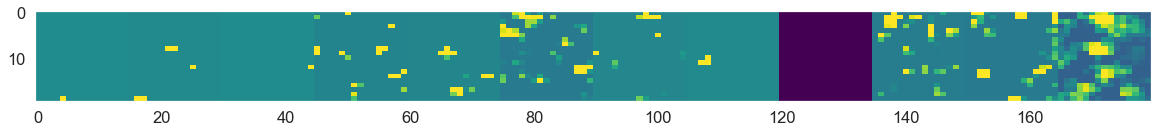

In [75]:
n_features = featuresfinal[0][0].shape[-1]  # number of features in the feature map
size1 = featuresfinal[0][0].shape[ 1]  # feature map shape (1, size, size, n_features)
size2 = featuresfinal[0][0].shape[ 2]   

# We will tile our images in this matrix
display_grid = np.zeros((size1, size2 * 12))
for i in range(500,512):
      x  = featuresfinal[0][0][0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, (i-500) * size2 : (i + 1-500) * size2] = x# Display the grid
scale = 20. / 12
plt.figure( figsize=(scale * 12, scale) )
plt.grid  ( False )
plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [ ]:
t-SNE visualization of features

In [69]:
total_dataset=features_final
all_image_features=[]
all_image_name=[]

for i in range(4):
    for j in range(len(features_final_test[i])):
        total_dataset[i].append(features_final_test[i][j])

for i in range(4):
    X1=total_dataset[i]
    Y1=[yy[i]]*len(X1)
    for n in range(len(X1)):
        XX1=np.mean(X1[n][0],axis=(0,1))
        all_image_features.append(XX1.flatten())
        all_image_name.append(Y1[n])


In [71]:
tsne = TSNE(n_components=2).fit_transform(all_image_features)
def scale_to_range(x):
   
    val_range = (np.max(x) - np.min(x))
    From_zero = x - np.min(x)
    return From_zero / val_range

	 
# extract x and y coordinates representing the positions of the images on T-SNE plot

tsne_x = tsne[:, 0]
tsne_y = tsne[:, 1]
	 
tsne_x = scale_to_range(tsne_x)
tsne_y = scale_to_range(tsne_y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

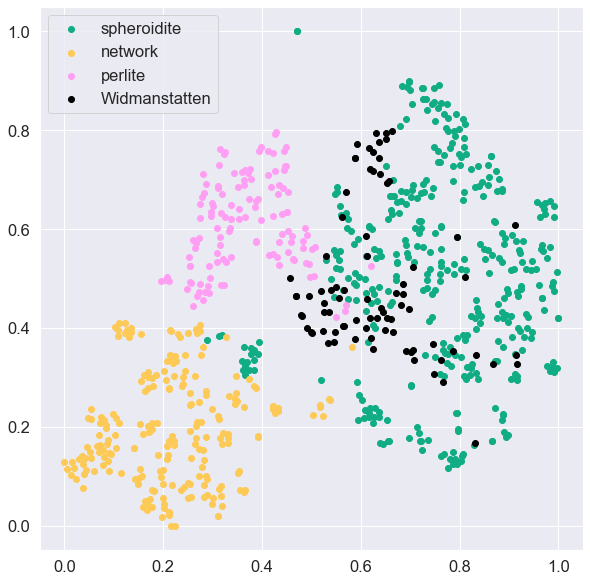

In [73]:
microconstituents={
    'spheroidite' : [16, 172, 132],
    'network' : [254, 202, 87],
    'perlite' : [255, 159, 243],
    'Widmanstatten' : [0, 0, 0],
}

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(aspect='equal') 


for label in microconstituents:
    
    indices = [i for i, l in enumerate(all_image_name) if l == label]
    current_tsne_x = np.take(tsne_x, indices)
    current_tsne_y = np.take(tsne_y, indices)
    color = np.array(microconstituents[label], dtype=np.float) / 255
    ax.scatter(current_tsne_x, current_tsne_y, c=color, label=label)
 
ax.legend(loc='best')
plt.show()

Defining parameters for TWSVM

In [97]:
h = .02  # step size in the mesh
params1 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':0,'kernel_parameter': 1,'fuzzy' :0}
params2 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':3,'kernel_parameter': 2,'fuzzy' :0}
params3 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':3,'kernel_parameter': 2,'fuzzy' :1}
params4 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':1,'kernel_parameter': 1,'fuzzy' :0}     #Linear kernel
params5 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':2,'kernel_parameter': 3,'fuzzy' :0}#Polynomial kernel,degree=2
params6 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':3,'kernel_parameter': 10,'fuzzy' :0}  #RBF, gamma=0.01,p=10
params7 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':3,'kernel_parameter': 1,'fuzzy' :0}  #RBF, gamma=1,p=1
params8 = {'Epsilon_1': 0.1, 'Epsilon_2': 0.1, 'C1': 1, 'C2': 1,'kernel_type':3,'kernel_parameter': 0.1,'fuzzy' :0}  #RBF, p=12



### Build one-vs-one binary classifiers using SVM

In [108]:
with open('objsfinal.pkl','rb') as f:  # Python 3: open(..., 'rb')
    features_final,features_final_test,features_pands,features_pandw,features_mar = pickle.load(f)
f.close()

classifier_names=[0,0,0,0,0,0]
bi_classifers=[]
c=0

for ii in range(4-1):
    for jj in range(ii+1,4):
        X1=features_final[ii]
        y1=[yy[ii]]*len(X1)
        X2=features_final[jj]
        y2=[yy[jj]]*len(X2)
        y=y1[:]
        classifier_names[nn]=yy[ii]+" "+yy[jj]
        for n in y2:
            y.append(n)
        X=[]
        for n in range(len(X1)):
            XX1=np.mean(X1[n][0],axis=(0,1))
            X.append(XX1.flatten())
        for n in range(len(X2)):
            XX2=np.mean(X2[n][0],axis=(0,1))
            X.append(XX2.flatten())
        X=np.array(X)
        y=np.array(y)
        #For TWSVM
        bi_classifers.append(OneVsOneClassifier(TWSVMClassifier(**params3)).fit(X,y))   
        c+=1

### Build multi-class classifier using voting

In [109]:
def voting(bi_classifers,X):
    y=[]
    for j in range(len(bi_classifers)):
       y.append(bi_classifers[j].predict(X))        
    y=np.array(y)
    axis=0
    unique, indices = np.unique(y, return_inverse=True)
    return unique[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(y.shape),
                                None, np.max(indices) + 1), axis=axis)]
Xv=[]
yv=[]
for ii in range(4):
     X1=features_final[ii]
     yv.extend([yy[ii]]*len(X1))
     for n in range(len(X1)):
        XX1=np.mean(X1[n][0],axis=(0,1))
        Xv.append(XX1.flatten())
    
voteclassifier= OneVsOneClassifier(TWSVMClassifier(**params3)).fit(Xv, yv)     

### Evaluate multi-class classifier using test set

In [110]:
scores=[0,0,0,0]
voting_scores=[]
for ii in range(4):
    X1=features_final_test[ii]
    y1=[yy[ii]]*len(X1)
    y=y1[:]
    X=[]
    scores[ii]=[]
    for n in range(len(X1)):
        XX1=np.mean(X1[n][0],axis=(0,1))
        X.append(XX1.flatten())
    X=np.array(X)
    for j in range(len(bi_classifers)):
        scores[ii].append(1-bi_classifers[j].score(X,y))
    #y_voting=voting(biclassifers,X)
    y_voting=voteclassifier.predict(X)
    voting_score=0
    for i in range(len(y)):
        if y[i]==y_voting[i]:
            voting_score+=1
    voting_score=voting_score/len(y)
    voting_scores.append(1-voting_score)


Printing error scores for binary classification problems and voting

In [ ]:
print("Scores= ")
print(scores)
print("Voting Scores\n")
print(voting_scores)

### Make predictions and write results to excel files

In [70]:
X1=featuresfinalpands
X=[]
for n in range(len(X1)):
    XX1=np.mean(X1[n][0],axis=(0,1))
    #XX1=X1[n][4][0]
    X.append(XX1.flatten())
X=np.array(X)
yvoting=voting(biclassifers,X)
ybinary=biclassifers[1].predict(X)
ypandsvote=yvoting 
ypandsbina=ybinary

X1=featuresfinalpandw
X=[]
for n in range(len(X1)):
    XX1=np.mean(X1[n][0],axis=(0,1))
    #XX1=X1[n][4][0]
    X.append(XX1.flatten())
X=np.array(X)
yvoting=voting(biclassifers,X)
ybinary=biclassifers[5].predict(X)
ypandwvote=yvoting 
ypandwbina=ybinary

X1=featuresfinalmar
X=[]
for n in range(len(X1)):
    XX1=np.mean(X1[n][0],axis=(0,1))
    #XX1=X1[n][4][0]
    X.append(XX1.flatten())
X=np.array(X)
yvoting=voting(biclassifers,X)
ymarvote=yvoting 

classifierdictionary={}
classifierdictionary['microid']=martensitename
classifierdictionary['predicted label']=ymarvote
Results = pd.DataFrame(classifierdictionary, index=None)
writer = pd.ExcelWriter('marvote.xlsx')
Results.to_excel(writer,'Sheet1')
writer.save()

classifierdictionary={}
classifierdictionary['microid']=pearandsphname
classifierdictionary['predicted label']=ypandsvote
Results = pd.DataFrame(classifierdictionary, index=None)
writer = pd.ExcelWriter('pandsvote.xlsx')
Results.to_excel(writer,'Sheet1')
writer.save()

classifierdictionary={}
classifierdictionary['microid']=pearandsphname
classifierdictionary['predicted label']=ypandsbina
Results = pd.DataFrame(classifierdictionary, index=None)
writer = pd.ExcelWriter('pandsbina.xlsx')
Results.to_excel(writer,'Sheet1')
writer.save()

classifierdictionary={}
classifierdictionary['microid']=pearandwidname
classifierdictionary['predicted label']=ypandwbina
Results = pd.DataFrame(classifierdictionary, index=None)
writer = pd.ExcelWriter('pandwbina.xlsx')
Results.to_excel(writer,'Sheet1')
writer.save()

classifierdictionary={}
classifierdictionary['microid']=pearandwidname
classifierdictionary['predicted label']=ypandwvote
Results = pd.DataFrame(classifierdictionary, index=None)
writer = pd.ExcelWriter('pandwvote.xlsx')
Results.to_excel(writer,'Sheet1')
writer.save()
